In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

This is for Lesson 2 Quiz question 9.  The idea is to take the bear example and recreate it for another image type to reinforce what was learned.  Here it goes.

Painters:
Santiago Rusinol
Paul Cezanne
Salvador Dali
Frida Kahlo
Claude Monet
Paul Gauguin

get necessary binaries

In [6]:
!pip install -Uqq fastbook
!pip install -Uqq duckduckgo_search

In [7]:
from fastbook import *
from fastai.vision.widgets import *

In [8]:
import os
import fastai
from duckduckgo_search import DDGS
from fastdownload import download_url
from fastcore.all import *
from fastai.vision.all import *
from time import sleep

define function to get images

In [9]:
def find_images(prompt, max_images=1):
    print(f"Searching for image: {prompt}")
    return L(DDGS().images(prompt, max_results=max_images)).itemgot('image')

define function to get test images to be used to test model prior to deployment.

In [29]:
def get_test_image():
    dest = 'images/test.jpg'
    test_path = Path('images')
    test_img = find_images('Santiago Rusinol Painting', max_images=1)
    if not test_path.exists():
        test_path.mkdir()
    return download_images(dest, urls=test_img)

Define the 'painters' and the path where they will be saved

In [12]:
painters = 'Santiago Rusinol', 'Paul Cezanne', 'Salvador Dali', 'Frida Kahlo', 'Claude Monet', 'Paul Gauguin'
path = Path('Painters')

Download images of paintings

In [13]:
if not path.exists():
    path.mkdir()
for o in painters:
    dest = (path / o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=find_images(f'{o} painting', max_images=50))
    sleep(10)

Searching for image: Santiago Rusinol painting
Searching for image: Paul Cezanne painting
Searching for image: Salvador Dali painting
Searching for image: Frida Kahlo painting
Searching for image: Claude Monet painting
Searching for image: Paul Gauguin painting


In [14]:
fns = get_image_files(path)
fns

(#590) [Path('Painters/Salvador Dali/5a694b3d-622c-4bea-a598-9377055cbb2d.jpg'),Path('Painters/Salvador Dali/757d8f2f-089c-425e-b080-de4b3e22dc36.jpg'),Path('Painters/Salvador Dali/0aeae627-1fe1-4388-9bfd-02d6e9255dec.jpg'),Path('Painters/Salvador Dali/60a5911e-fa8d-4574-af85-a791d4e724e6.jpg'),Path('Painters/Salvador Dali/681c6605-ec4f-45a0-a4b7-076701df3e68.jpg'),Path('Painters/Salvador Dali/07617675-0773-472d-826c-6c995e3b40a7.jpg'),Path('Painters/Salvador Dali/7ff47894-b48b-40c7-802a-11c7fe01be4a.jpg'),Path('Painters/Salvador Dali/078ab1cb-5e67-42e8-a387-c774a3730005.jpg'),Path('Painters/Salvador Dali/6e7fdbd1-ddfb-43ab-b2c1-e05562b1a378.jpg'),Path('Painters/Salvador Dali/a5059ef9-5db5-4f2e-805a-aa1a206252f3.jpg')...]

In [15]:
failed = []
failed = verify_images(fns)
num_failed = len(failed)
print(num_failed)
failed

2


(#2) [Path('Painters/Salvador Dali/47521330-f1fb-440a-9d74-0612381dc912.jpg'),Path('Painters/Frida Kahlo/1f5eae82-28b4-4855-bf0b-25b6624831dd.jpg')]

In [16]:
if num_failed != 0:
    failed.map(Path.unlink)
    print(f'Removed {num_failed} files.')
else:
    print('All files verified.')

Removed 2 files.


### Create DataLoaders
Using fastai data block API

In [17]:
paintings = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=101),
    get_y = parent_label,
    item_tfms = Resize(512)
)

dls = paintings.dataloaders(path)

Preparing images for Model training

In [18]:
paintings = paintings.new(item_tfms = RandomResizedCrop(512, min_scale=0.5))
dls = paintings.dataloaders(path)

Create "Learner" and fine-tune.

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,2.337075,1.077276,0.324786,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.621537,0.529366,0.128205,00:25
1,0.442947,0.219286,0.051282,00:25
2,0.311750,0.139720,0.025641,00:26
3,0.237270,0.097756,0.017094,00:25
4,0.186750,0.082827,0.017094,00:26


Visualize model mistakes using **Confusion Matrix**

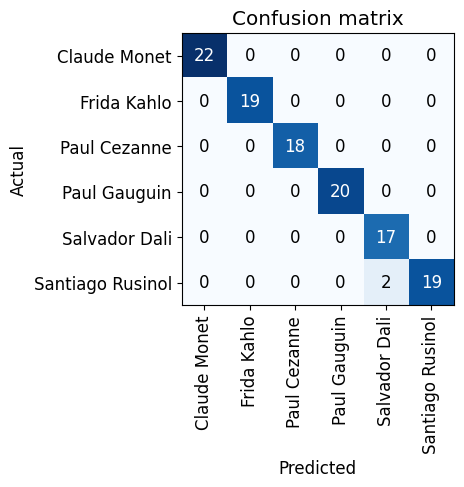

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

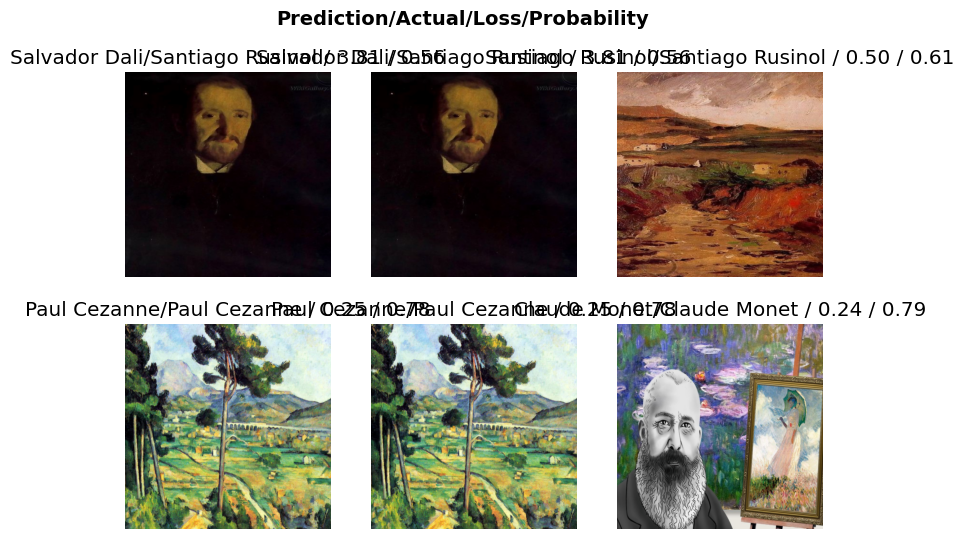

In [21]:
interp.plot_top_losses(6, nrows=2)

## Using the model in an application (online)

In [22]:
learn.export()

check for the files

In [23]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [24]:
learn_inf = load_learner(path/'export.pkl')

In [34]:
prediction = learn_inf.predict('/kaggle/working/images/test.jpg/1a8414bb-53e9-46a4-9067-242317a3eded.jpg')
prediction

('Santiago Rusinol',
 tensor(5),
 tensor([6.1754e-04, 4.7332e-05, 2.1970e-04, 2.0390e-05, 9.0609e-07, 9.9909e-01]))

## Building the GUI

In [36]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [38]:
img = PILImage.create(btn_upload.data[-1])

# Display Image

out_pl = widgets.Output()
out_pl.clear_output()
with out_pl:
    display(img.to_thumb(256,256))
out_pl

Output()

In [39]:
pred,pred_idx,probs = learn_inf.predict(img)

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Santiago Rusinol; Probability: 0.9884')

In [41]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

click event handler, function that will be called when pressed

In [43]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(256,256))
    pred,pred_idx,probs = learn_ing.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

Put all widgets in a vertical box to complete GUI

In [ ]:
btn_upload = widgets.FileUpload()

In [44]:
VBox([widgets.Label('Select your painting.'),
     btn_upload, btn_run, out_pl, lbl_pred])

Turn notebook into app

In [45]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

  Obtaining dependency information for voila from https://files.pythonhosted.org/packages/25/28/7b9d6c2597bd86b25936df550f9b88319ee79721f095c90dca822c053692/voila-0.5.5-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 13.5 MB/s eta 0:00:0000:0100:01
Config option `kernel_spec_manager_class` not recognized by `EnableServerExtensionApp`.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.5.5 OK
